In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import root_scalar

# Plots for the Poisson FOCuS JASA paper

These notebooks serve as references for all the Python-generated image graphics in the paper.

## Binning GRB data and creating plots from it

* Plot for short binwidth
* Plot for long binwidth

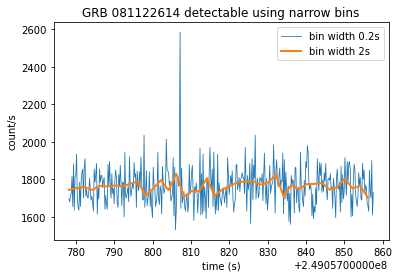

In [4]:
#plot for burst triggering short binwidths
grb_id = '081122614'

bin_widths = [0.2, 2]
lws = {bin_widths[0]:0.8, bin_widths[1]:2}

filepath = f'data/{grb_id}_GBM.txt'

grb_counts = pd.read_csv(filepath, header=None)
first = grb_counts.iloc[0, 0]; last = grb_counts.iloc[-1, 0]

for bin_width in bin_widths:
    bins = np.arange(first, last+bin_width, bin_width)
    bin_map = pd.cut(grb_counts[0], bins=bins).apply(lambda I: I.left)
    bin_series = pd.DataFrame(bin_map).groupby(0)[0].count().iloc[0:-int(250/bin_width)]/bin_width
    plt.plot(bin_series.index, bin_series, label=f"bin width {bin_width}s", lw=lws[bin_width])
    
plt.xlabel("time (s)")
plt.ylabel("count/s")
plt.title(f"GRB {grb_id} detectable using narrow bins")
plt.legend()

plt.savefig('plots/narrow_grb.png', dpi = 150)
plt.show()

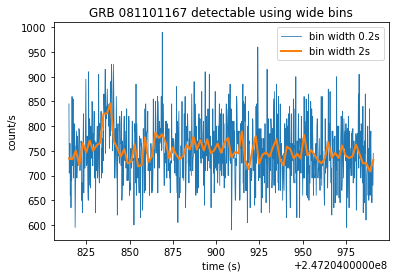

In [5]:
#plot for burst triggering long binwidths

grb_id = '081101167'
bin_widths = [0.2, 2]
lws = {bin_widths[0]:0.8, bin_widths[1]:2}

filepath = f'data/{grb_id}_GBM.txt'
grb_counts = pd.read_csv(filepath, header=None)
first = grb_counts.iloc[0, 0]; last = grb_counts.iloc[-1, 0]
for bin_width in bin_widths:
    bins = np.arange(first, last+bin_width, bin_width)
    bin_map = pd.cut(grb_counts[0], bins=bins).apply(lambda I: I.left)
    bin_series = pd.DataFrame(bin_map).groupby(0)[0].count().iloc[0:-int(150/bin_width)]/bin_width
    plt.plot(bin_series.index, bin_series, label=f"bin width {bin_width}s", lw=lws[bin_width])
    
plt.xlabel("time (s)")
plt.ylabel("count/s")
plt.title(f"GRB {grb_id} detectable using wide bins")
plt.legend()

plt.savefig('plots/wide_grb.png', dpi = 150)
plt.show()

## Plots of Page and Window Method thresholds

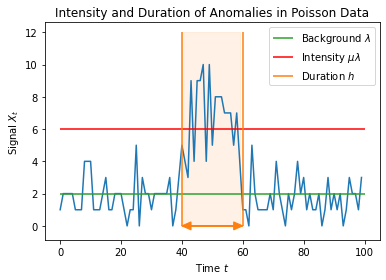

In [6]:
λ = 2
μ = 3
np.random.seed(51)

signal = np.concatenate([stats.poisson.rvs(mu = λ, size=40), stats.poisson.rvs(mu = μ*λ, size=20), stats.poisson.rvs(mu = λ, size=40)])
plt.plot(signal)
plt.hlines(λ, xmin=0, xmax=100, color="C2", label="Background $\lambda$")
plt.hlines(λ*μ, xmin=0, xmax=100, color="red", label="Intensity $\mu \lambda$")
plt.vlines([40, 60], ymin=0, ymax=12, color="C1", label="Duration $h$")
plt.fill_between(np.arange(40,60), 0, 12, alpha=0.1, color="C1")
plt.arrow(40, 0, 20, 0, head_length=3, head_width=0.5, length_includes_head=True, color="C1")
plt.arrow(60, 0, -20, 0, head_length=3, head_width=0.5, length_includes_head=True, color="C1")
plt.xlabel("Time $t$")
plt.ylabel("Signal $X_t$")
plt.title("Intensity and Duration of Anomalies in Poisson Data")
plt.legend()

plt.savefig('plots/two_dimensions_anomalies_poisson.png', dpi = 150)
plt.show()

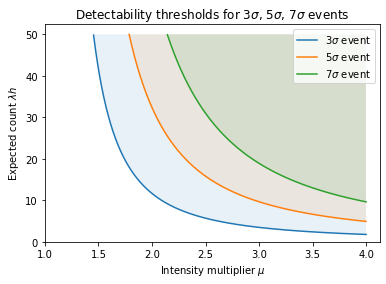

In [10]:
y = 50
x = 4

λ = 1
h = np.linspace(0.01, y, 20000)
k_list = (3, 5, 7)

for k in k_list:
    λ = 4
    μ = np.linspace(1.01, x, 2000)
    Threshold = k**2/2
    h = Threshold / (μ*np.log(μ)-μ+1) / λ
    λh = λ*h
    plt.plot(np.where(μ<y, μ, np.NaN), np.where(λh<y, λh, np.NaN),  label=f"{k}$\sigma$ event")
    plt.fill_between(np.where(μ<x, μ, np.NaN), np.where(λh<y, λh, np.NaN), y, alpha=0.1)

    
plt.ylabel("Expected count $\lambda h$")
plt.xlabel("Intensity multiplier $\mu$")
plt.ylim(ymin=0)
plt.xlim(xmin=1)
plt.title(f"Detectability thresholds for {k_list[0]}$\sigma$, {k_list[1]}$\sigma$, {k_list[2]}$\sigma$ events")
plt.legend()

plt.savefig('plots/detectability_threshold.png', dpi = 150)
plt.show()

## Plots of Windows

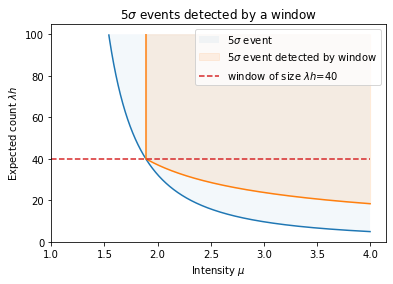

In [13]:
λ = 5
μ = np.linspace(1.5, 4, 2000)

k=5
threshold = k**2/2
λh = threshold/(μ*np.log(μ)-μ+1)

μ = np.flip(μ[λh<100])
λh = np.flip(λh[λh<100])
h = λh/λ

y = 100
x = 4

def switcher(λh, threshold=threshold, x=x):
    #solves λh(μ*np.log(μ)-μ+1)=threshold for μ
    return root_scalar(lambda μ, z: μ*np.log(μ)-μ+1-z, args = (threshold/λh), bracket=[1+np.sqrt(threshold/λh), x]).root

plt.plot(np.where(μ<x, μ, np.NaN), np.where(λh<y, λh, np.NaN))
plt.fill_between(np.where(μ<x, μ, np.NaN), np.where(0.0001<λh, λh, np.NaN), 100, alpha=0.05, label=f"{k}$\sigma$ event")

for λh_window in [40]:
    μ_detected = (μ*λh_window/λ - (λh_window/λ - h))/h
    
    plt.plot(np.where(μ_detected<x, μ_detected, np.NaN), np.where(λh<λh_window, λh, np.NaN), color="C1")
    plt.fill_between(np.where(μ_detected<x, μ_detected, np.NaN), np.where(λh<λh_window, λh, np.NaN), 100, alpha=0.1, color="C1", label=f"{k}$\sigma$ event detected by window")
    plt.vlines(switcher(λh_window, threshold), ymin=λh_window, ymax=100, color="C1")
    plt.hlines(λh_window, xmin=1, xmax=x, color="C3", label=f"window of size $λh$={λh_window}", linestyle="dashed")

plt.ylabel("Expected count $\lambda h$")
plt.xlabel("Intensity $\mu$")
plt.ylim(ymin=0)
plt.xlim(xmin=1)
plt.legend()
plt.title(f"{k}$\sigma$ events detected by a window")

plt.savefig('plots/window_nogrid.png', dpi = 150)
plt.show()

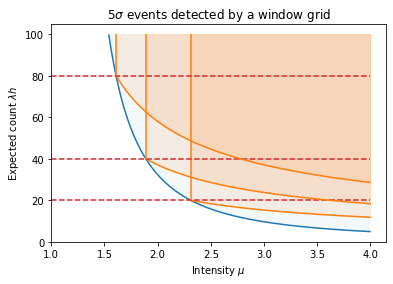

In [14]:
λ = 5
μ = np.linspace(1.5, 4, 2000)

k=5
threshold = k**2/2
λh = threshold/(μ*np.log(μ)-μ+1)

μ = np.flip(μ[λh<100])
λh = np.flip(λh[λh<100])
h = λh/λ

y = 100
x = 4

def switcher(λh, threshold=threshold, x=x):
    #solves λh(μ*np.log(μ)-μ+1)=threshold for μ
    return root_scalar(lambda μ, z: μ*np.log(μ)-μ+1-z, args = (threshold/λh), bracket=[1+np.sqrt(threshold/λh), x]).root

plt.plot(np.where(μ<x, μ, np.NaN), np.where(λh<y, λh, np.NaN),  label=f"{k}$\sigma$ event")
plt.fill_between(np.where(μ<x, μ, np.NaN), np.where(0.0001<λh, λh, np.NaN), 100, alpha=0.05)

for λh_window in (20, 40, 80):
    μ_detected = (μ*λh_window/λ - (λh_window/λ - h))/h
    
    plt.plot(np.where(μ_detected<x, μ_detected, np.NaN), np.where(λh<λh_window, λh, np.NaN), color="C1")
    plt.hlines(λh_window, xmin=1, xmax=x, color="C3", linestyle="dashed")
    plt.fill_between(np.where(μ_detected<x, μ_detected, np.NaN), np.where(λh<λh_window, λh, np.NaN), 100, alpha=0.1, color="C1")
    plt.vlines(switcher(λh_window, threshold), ymin=λh_window, ymax=100, color="C1")

plt.ylabel("Expected count $\lambda h$")
plt.xlabel("Intensity $\mu$")
plt.ylim(ymin=0)
plt.xlim(xmin=1)
plt.title(f"{k}$\sigma$ events detected by a window grid")

plt.savefig('plots/window_grid.png', dpi = 150)
plt.show()

## Comparison of Page and Window

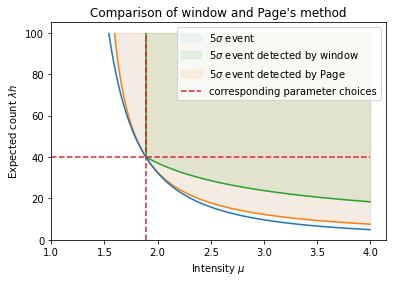

In [15]:
λ = 5
μ = np.linspace(1.5, 4, 2000)

k=5
threshold = k**2/2
λh = threshold/(μ*np.log(μ)-μ+1)

μ = np.flip(μ[λh<100])
λh = np.flip(λh[λh<100])
h = λh/λ

y = 100
x = 4


def switcher(λh, threshold=threshold, x=x):
    #solves λh(μ*np.log(μ)-μ+1)=threshold for μ
    return root_scalar(lambda μ, z: μ*np.log(μ)-μ+1-z, args = (threshold/λh), bracket=[1+np.sqrt(threshold/λh), x]).root

plt.plot(np.where(μ<x, μ, np.NaN), np.where(λh<y, λh, np.NaN), color="C0", zorder=5)
plt.fill_between(np.where(μ<x, μ, np.NaN), np.where(0.0001<λh, λh, np.NaN), 100, alpha=0.05, label=f"{k}$\sigma$ event", color="C0")


for λh_window in [40]:
    μ_detected = (μ*λh_window/λ - (λh_window/λ - h))/h
    
    plt.plot(np.where(μ_detected<x, μ_detected, np.NaN), np.where(λh<λh_window, λh, np.NaN), color="C2")
    plt.fill_between(np.where(μ_detected<x, μ_detected, np.NaN), np.where(λh<λh_window, λh, np.NaN),
                     100, alpha=0.1, color="C2", label=f"{k}$\sigma$ event detected by window")
    plt.vlines(switcher(λh_window, threshold), ymin=λh_window, ymax=100, color="C2")
    plt.hlines(λh_window, xmin=1, xmax=x, color="C3", linestyle="dashed")


page_μ = 2
detectability_zone = threshold/(μ*np.log(page_μ)-page_μ+1)

for page_μ in [switcher(40)]:
    detectability_zone = threshold/(μ*np.log(page_μ)-page_μ+1)
    
    plt.plot(μ, np.where((0<detectability_zone)&(detectability_zone<y), detectability_zone, np.nan), color="C1")

    plt.fill_between(μ, np.where((0<detectability_zone)&(detectability_zone<y), detectability_zone, np.nan),
                     100, alpha=0.1, color="C1", label=f"{k}$\sigma$ event detected by Page")

    plt.vlines(page_μ, 0, y, color="C3", linestyle="dashed", label=f"corresponding parameter choices",)

   
    
plt.ylabel("Expected count $\lambda h$")
plt.xlabel("Intensity $\mu$")
plt.ylim(ymin=0)
plt.xlim(xmin=1)
plt.legend()
plt.title("Comparison of window and Page's method")

plt.savefig('plots/page_window_comparison.png', dpi = 150)
plt.show()

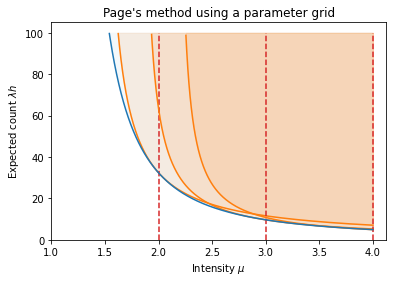

In [16]:
λ = 5
μ = np.linspace(1.5, 4, 2000)

k=5
threshold = k**2/2
λh = threshold/(μ*np.log(μ)-μ+1)

μ = np.flip(μ[λh<100])
λh = np.flip(λh[λh<100])
h = λh/λ

y = 100
x = 4

page_μ = 2

detectability_zone = threshold/(μ*np.log(page_μ)-page_μ+1)

plt.fill_between(np.where(μ<x, μ, np.NaN), np.where(0.0001<λh, λh, np.NaN), y, alpha=0.05) 

for page_μ in [2, 3, 4]:
    detectability_zone = threshold/(μ*np.log(page_μ)-page_μ+1)
    
    plt.plot(μ, np.where((0<detectability_zone)&(detectability_zone<y), detectability_zone, np.nan), color="C1")

    plt.fill_between(μ, np.where((0<detectability_zone)&(detectability_zone<y), detectability_zone, np.nan), 100, alpha=0.1, color="C1")

    plt.vlines(page_μ, 0, y, color="C3", linestyle="dashed")

    
plt.plot(np.where(μ<x, μ, np.NaN), np.where(λh<y, λh, np.NaN),  label=f"{k}$\sigma$ event", zorder=5)
   
    
plt.ylabel("Expected count $\lambda h$")
plt.xlabel("Intensity $\mu$")
plt.ylim(ymin=0)
plt.xlim(xmin=1)
plt.title("Page's method using a parameter grid")

plt.savefig('plots/page_grid.png', dpi = 150)
plt.show()

## $\mu_{\text{min}}$ calculations

In [24]:
threshold = 12.5
x = 4

def switcher(λh, threshold=threshold, x=x):
    #solves λh(μ*np.log(μ)-μ+1)=threshold for μ
    return root_scalar(lambda μ, z: μ*np.log(μ)-μ+1-z, args = (threshold/λh), bracket=[1+np.sqrt(threshold/λh), x]).root

table = pd.DataFrame()
table["timescale"] = [0.05, 1, 60, 3600]
table["λh_max"] = table["timescale"]*2000
table["μ_min"] = table["λh_max"].apply(switcher)
table

,timescale,λh_max,μ_min
0,0.05,100.0,1.540128
1,1.00,2000.0,1.113868
2,60.00,120000.0,1.014468
3,3600.00,7200000.0,1.001864


# Curve Plots

In [18]:
def curve(μ, a=0, b=0):
    return np.maximum(a*np.log(μ)-b*(μ-1), -1)

def intersection(a1, b1, a2, b2):
    z = (a1-a2)/(b1-b2)
    output = root_scalar(lambda μ,z : z*np.log(μ)-(μ-1), args = (z), bracket=[z, 2*z])
    return output.root

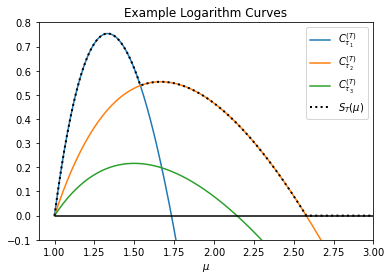

In [19]:
μ = np.linspace(1, 3, 301)

a1=20; b1=15; C1=curve(μ, a=a1, b=b1)
a2=5; b2=3; C2 = curve(μ, a=a2, b=b2)
a3=3; b3=2; C3 = curve(μ, a=a3, b=b3)
μ12 = intersection(a1, b1, a2, b2)

fig, ax = plt.subplots()

plt.plot(μ, C1, label="$C_{τ_1}^{(T)}$")
plt.plot(μ, C2, label="$C_{τ_2}^{(T)}$")
plt.plot(μ, C3, label="$C_{τ_3}^{(T)}$")
plt.hlines(y=0, xmin=1, xmax=3, color='black')
ax.set(xlim=(0.9, 3), ylim=(-0.1, 0.8))

plt.plot(μ, np.maximum(np.maximum(C1, C2), 0), color="black", linestyle="dotted", label="$S_T(μ)$", linewidth=2)
plt.xlabel("$μ$")
plt.title("Example Logarithm Curves")
plt.legend()

plt.savefig('plots/example_logarithm_curves.png', dpi = 150)
plt.show()